# **Modélisation du système de train électrique**

Baptiste Rouquette

Amir Ahaddad

Julien Sagnes

Cette modélisation vise à simuler le déplacement d'un train électrique le long d'une ligne, en prenant en compte l'évolution de la tension aux bornes du train, du courant consommé et de la puissance mécanique nécessaire. Ce modèle sera développé sans prendre en compte la présence d'une batterie dans un premier temps.

## **I - Paramètres de base**

Les paramètres de base du système sont les suivants :

- Masse du train : $M = 70 \, \text{tonnes} = 70000 \, \text{kg}$

- Gravité : $g = 9.81 \, \text{m/s}^2$

- Rendement du moteur et des convertisseurs : $\eta = 0.8$

- Tension à la sous-station : $V_{\text{sst}} = 790 \, \text{V}$

- Résistance de la sous-station : $R_{\text{sst}} = 33 \, \text{m}\Omega = 0.033 \, \Omega$

- Résistance linéique du câble aérien : $\rho_{\text{LAC}} = 131 \times 10^{-6} \, \Omega/\text{m}$

- Résistance linéique des rails : $\rho_{\text{rail}} = 18 \times 10^{-6} \, \Omega/\text{m}$

- Consommation des systèmes embarqués : $P_{\text{emb}} = 35 \, \text{kW} = 35000 \, \text{W}$

In [4]:
rho_LAC = 95e-6
rho_rail = 10-6
V_sst = 790
R_sst = 33e-3
M = 70000
A_0 = 780
A_1 = 6.4e-3
B_0 = 0
B_1 = 0.14*3600/(1e6)
C_0 = 0.3634*3600**2/1e9
C_1 = 0
alpha = 0
g = 9.81
rend = 0.9
P_emb = 35000

## **II - Étapes de la modélisation sans batterie**

### **A - Calcul de la position, vitesse et accélération**

Dans un premier temps, nous allons calculer la cinématique du train qui nous permettra de déterminer d'autres valeurs par la suite. Nous approximons les dérivées de la position et de la vitesse par différences finies, en utilisant un schéma décentré aval.

In [5]:
#importation des bibiothèques
import os
import numpy as np
import matplotlib.pyplot as plt

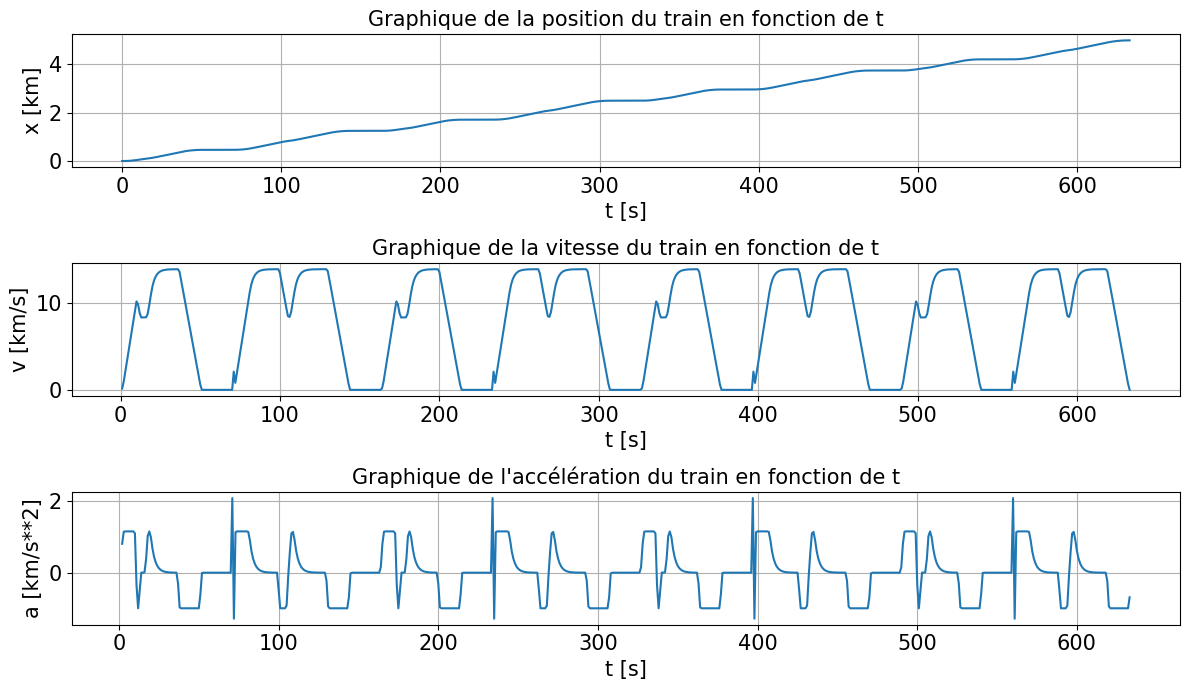

In [6]:
#Initialiser les paramètre de plot
parameters = {"axes.titlesize": 15, "axes.labelsize" : 15, "xtick.labelsize": 15, "ytick.labelsize": 15}
plt.rcParams.update(parameters)

# Vérifier si le fichier existe
file_path = 'marche_train.txt'

if os.path.exists(file_path):
    data = np.loadtxt(file_path)
    
    t = data[:, 0]
    x = data[:, 1]/(10**3) #conversion en kilomètres
    
    # Créer la plot
    plt.figure(1, figsize = (12,7))
    plt.subplot(3,1,1)
    plt.plot(t, x)
    plt.xlabel('t [s]')
    plt.ylabel('x [km]')
    plt.title('Graphique de la position du train en fonction de t')
    plt.grid(True)
else:
    print(f"Le fichier {file_path} n'a pas été trouvé. Vérifiez le chemin.")
    raise TypeError
    
# On reprend x en mètres
x = data[:, 1]
v = np.zeros(len(x) - 1)

for n in range(1, len(x)):
        v[n - 1] = (x[n] - x[n - 1]) / (t[n] - t[n - 1])

plt.subplot(3,1,2)
plt.plot(t[1:], v)
plt.xlabel('t [s]')
plt.ylabel('v [km/s]')
plt.title('Graphique de la vitesse du train en fonction de t')
plt.grid(True)

a = np.zeros(len(v) - 1)

for n in range(1, len(v)):
        a[n - 1] = (v[n] - v[n - 1]) / (t[n] - t[n - 1])

plt.subplot(3,1,3)
plt.plot(t[2:], a)
plt.xlabel('t [s]')
plt.ylabel('a [km/s**2]')
plt.title("Graphique de l'accélération du train en fonction de t")
plt.grid(True)
plt.tight_layout()

### **B - Calcul de la force résistive**

La force résistive est donnée par :

$F_{\text{résistive}}(v) = (A_0 + A_1 M) + (B_0 + B_1 M) v + (C_0 + C_1 M) v^2$

Les termes $A_0, A_1, B_0, B_1, C_0, C_1$ sont des constantes qui dépendent des caractéristiques du train et de la voie.

$A_0 = 780, \quad A_1 = 6.4 \, \text{N/tonne}, \quad B_0 = 0, \quad B_1 = 0.14 \, \text{N/(tonne km/h)}$

$C_0 = 0.3634 \, \text{N/(km h$^{-1}$)}, \quad C_1 = 0$


Ici, la dimension de $\rho$ indique que la section du câble est déjà prise en compte : $R = \rho * L/S$ (L longueur, S : section)

$R_{eq1} = Rsst + R_{lac1} + R_{rail1}$

$R_{eq2} = Rsst + R_{lac2} + R_{rail2}$

Les deux sont en parallèles donc $R_{eq} = R_{eq1} \cdot R_{eq2}/(R_{eq1}+R_ {eq2})$

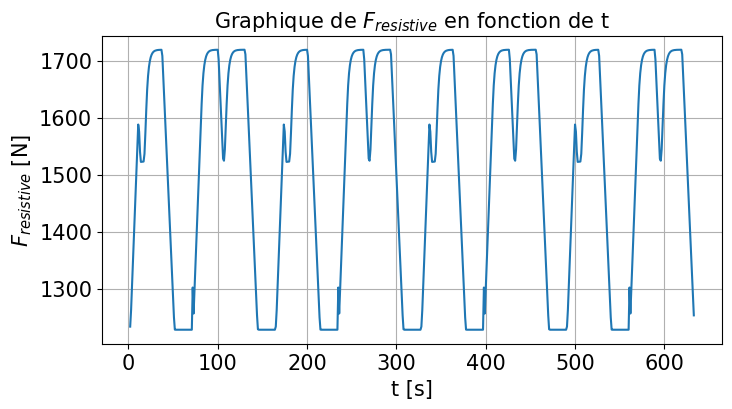

In [7]:
F_resistive = np.zeros(len(v))
F_resistive = (A_0 + A_1*M) + (B_0 + B_1*M)*v[:-1] + (C_0 + C_1*M)*v[:-1]**2 

plt.figure(2, figsize = (8,4))
plt.plot(t[2:], F_resistive)
plt.xlabel('t [s]')
plt.ylabel('$F_{resistive}$ [N]')
plt.title('Graphique de $F_{resistive}$ en fonction de t')
plt.grid(True)

### **C - Calcul de la force motrice**

La force motrice $F_{\text{motrice}}$ nécessaire pour surmonter les résistances et faire avancer le train est calculée en fonction de l'accélération $a(t)$ du train et de la pente $\alpha$ de la voie. La relation de la force motrice est, d'après la $2^{nd}$ loi de Newton :

$F_{\text{motrice}} = M \cdot a + M \cdot g \cdot \sin(\alpha) + F_{\text{résistive}}$

où :

- $M$ est la masse du train.
- $a$ est l'accélération du train, calculée à partir de la variation de sa vitesse \( v \).
- $g$ est l'accélération due à la gravité.
- $\alpha$ est la pente de la voie.

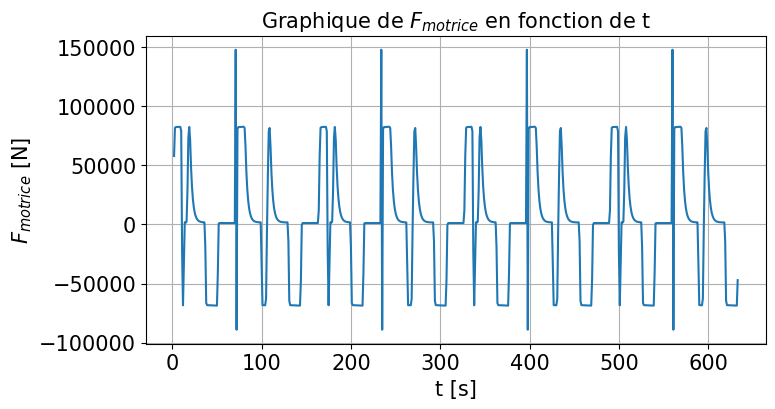

In [8]:
F_motrice = np.zeros(len(a))     
F_motrice = M*a + M*g*(np.sin(alpha)) + F_resistive

plt.figure(3, figsize = (8,4))
plt.plot(t[2:], F_motrice)
plt.xlabel('t [s]')
plt.ylabel('$F_{motrice}$ [N]')
plt.title('Graphique de $F_{motrice}$ en fonction de t')
plt.grid(True)

### **D - Calcul de la puissance mécanique**

La puissance mécanique $P_{\text{mécanique}}$ requise pour déplacer le train est donnée par :

$P_{\text{mécanique}} = F_{\text{motrice}} \cdot v$

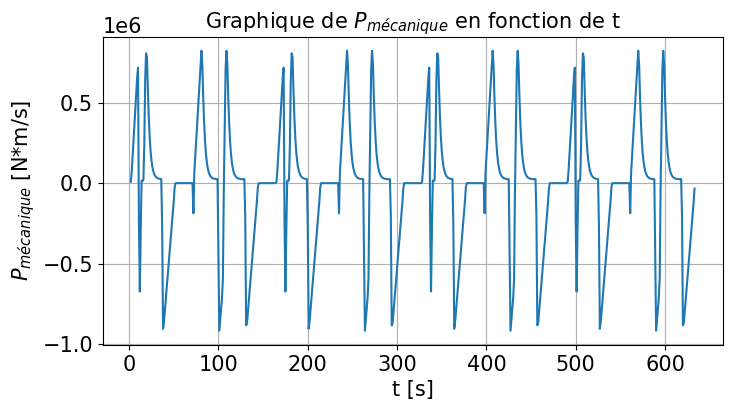

In [9]:
P_mécanique = np.zeros(len(a))  
P_mécanique = F_motrice * v[:-1]

plt.figure(4, figsize = (8,4))
plt.plot(t[2:], P_mécanique)
plt.xlabel('t [s]')
plt.ylabel('$P_{mécanique}$ [N*m/s]')
plt.title('Graphique de $P_{mécanique}$ en fonction de t')
plt.grid(True)

### **E - Calcul de la puissance électrique nécessaire**

La puissance électrique $P_{\text{électrique}}$ nécessaire pour faire fonctionner le train est calculée en prenant en compte l'efficacité du moteur et des convertisseurs. Elle est donnée par :



Si $P_{mécanique} \ge 0$:

$P_{\text{train}} = \frac{P_{\text{mécanique}}}{\eta} + P_{\text{emb}}$

Si $P_{mécanique} < 0$: 

$P_{\text{train}} = \eta * P_{\text{mécanique}} + P_{\text{emb}}$

où :

- $\eta$ est le rendement global de la conversion (80\%).
- $P_{\text{emb}}$ est la puissance constante nécessaire pour alimenter les systèmes embarqués (35 kW).


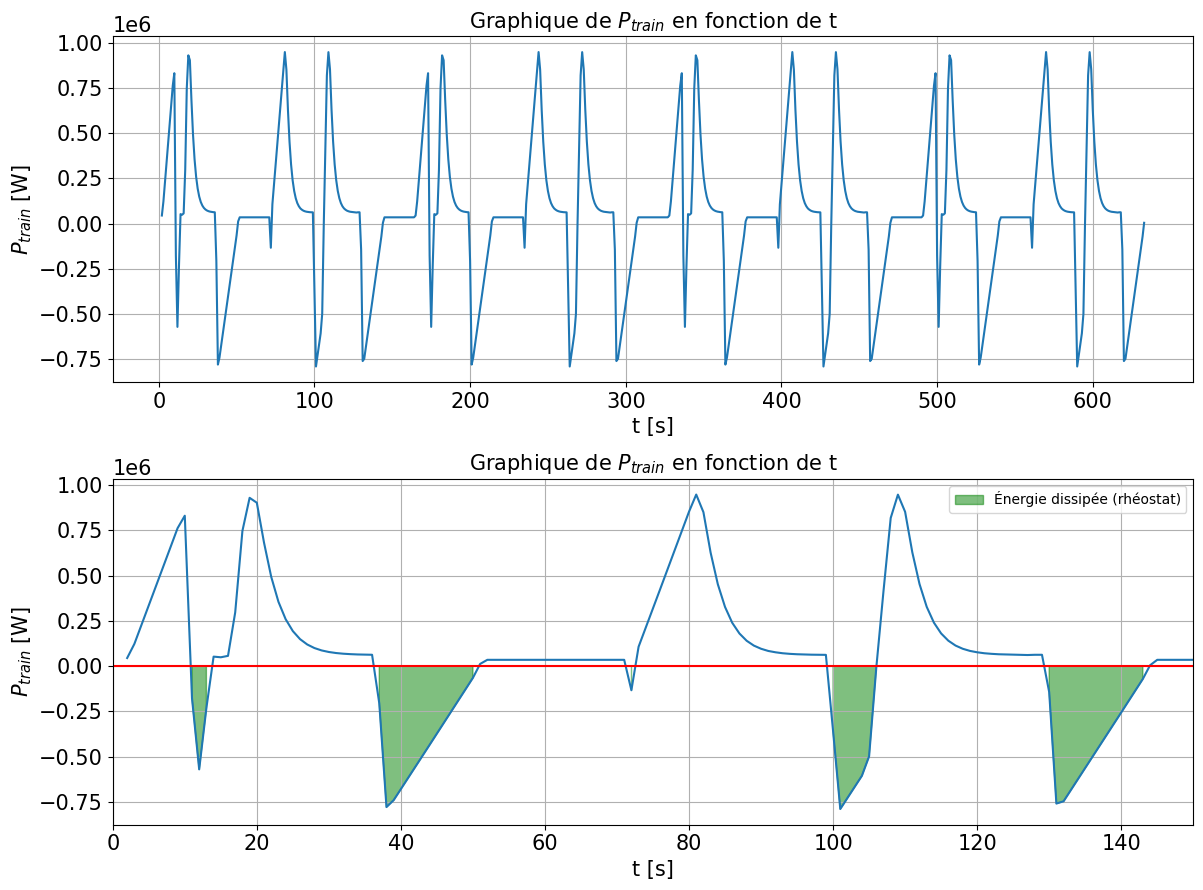

In [10]:

P_train = np.zeros(len(a))  
# Calcul de P_train
for i in range(len(P_train)):
    if P_mécanique[i] >= 0:
        P_train[i] = P_mécanique[i]/rend + P_emb
    else:
        P_train[i] = P_mécanique[i]*rend + P_emb
    
plt.figure(5, figsize = (12,9))
plt.subplot(2,1,1)
plt.plot(t[2:], P_train)
plt.xlabel('t [s]')
plt.ylabel('$P_{train}$ [W]')
plt.title('Graphique de $P_{train}$ en fonction de t')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t[2:], P_train)
plt.plot([0,150],[0,0], '-r')
plt.fill_between(t[2:], P_train, 0, where=(P_train <= 0), color='green', alpha=0.5, label='Énergie dissipée (rhéostat)')
plt.xlabel('t [s]')
plt.ylabel('$P_{train}$ [W]')
plt.title('Graphique de $P_{train}$ en fonction de t')
plt.xlim(0,150)
plt.legend()
plt.grid(True)

plt.tight_layout()



### **F - Calcul de la resistance équivalente**

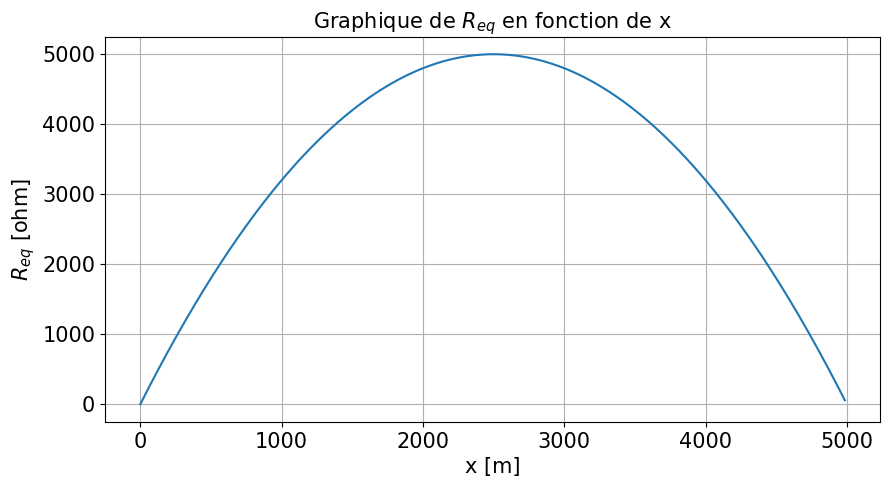

In [11]:
# Calcul de la résistance R_eq
# Calcul de R_eq1 calcul depuis sous-station 1
# Calcul de R_eq2 calcul depuis sous-station 2
# on a pris  les deux sous stations entre 2000 et 4000   metres 
R_lac1 = np.zeros(len(x))
R_rail1 = np.zeros(len(x))
R_lac2 = np.zeros(len(x))
R_rail2 = np.zeros(len(x))

# Sélection des deux sous-stations sachant que y'a une sous station chaque 2km 
L_sst1 = 0  # Position de la première sous-station
L_sst2 = 5000  # Position de la deuxième sous-station

# Trouver les indices correspondants aux deux sous-stations
mask1 = (x >= L_sst1) & (x < L_sst2)

# Calcul des résistances proportionnelles à la distance dans l'intervalle
d1 = x[mask1] - L_sst1
d2 = L_sst2 - x[mask1]

# Résistances pour chaque point dans l'intervalle
R_lac1[mask1] = rho_LAC * d1
R_rail1[mask1] = rho_rail * d1
R_lac2[mask1] = rho_LAC * d2
R_rail2[mask1] = rho_rail * d2

# Calcul des résistances équivalentes pour les deux sous-stations
R_eq1 = R_sst + R_lac1 + R_rail1
R_eq2 = R_sst + R_lac2 + R_rail2

# Résistance équivalente totale
R_eq = R_eq1 * R_eq2 / (R_eq1 + R_eq2)

# Affichage du graphique
plt.figure(6, figsize=(10,5))
plt.plot(x, R_eq)
plt.xlabel('x [m]')
plt.ylabel('$R_{eq}$ [ohm]')
plt.title('Graphique de $R_{eq}$ en fonction de x')
plt.grid(True)
plt.show()

### **G - Calcul de $V_{train}$ et $I_{train}$**

Le courant consommé par le train est obtenu en utilisant la relation suivante :  
$$
I_{\text{train}} = \frac{P_{\text{train}}}{V_{\text{train}}}
$$  
où $P_{\text{électrique}}$ est la puissance électrique nécessaire et $V_{\text{train}}$ est la tension aux bornes du train.

et  
$$
P_{\text{train}} = V_{\text{train}} \times I_{\text{train}} = V_{\text{train}} \frac{V_{\text{sst}} - V_{\text{train}}}{R_{\text{eq}}}.
$$

Cela permet de conclure que $V_{\text{train}}$ est solution de l'équation du second degré :

$$
V_{\text{train}}^2 - V_{\text{sst}} V_{\text{train}} + R_{\text{eq}} \cdot P_{\text{train}} = 0.
$$

Le discriminant de cette équation est donné par :

$$
\Delta = V_{\text{sst}}^2 - 4 R_{\text{eq}} \cdot P_{\text{train}}.
$$

L'équation n'admet pas de solution si $\Delta < 0$, c'est-à-dire si :

$$
P_{\text{train}} > \frac{V_{\text{sst}}^2}{4 R_{\text{eq}}}.
$$

Alors dans ce dernier cas, on estime que $V_{\text{sst}}^2 - 4 R_{\text{eq}} \cdot P_{\text{train}} = 0$, donc $P_{\text{train}} = \frac{1}{2} V_{sst}$

En d'autres termes, pour une position donnée du train, la LAC (Locomotive à Courant) ne peut pas fournir une puissance supérieure à $\frac{V_{\text{sst}}^2}{4 R_{\text{eq}}}$.

Si $\Delta \geq 0$, la solution pour $V_{\text{train}}$ est :

$$
V_{\text{train}} = \frac{1}{2} \left( V_{\text{sst}} \pm \sqrt{V_{\text{sst}}^2 - 4 R_{\text{eq}} \cdot P_{\text{train}}} \right).
$$

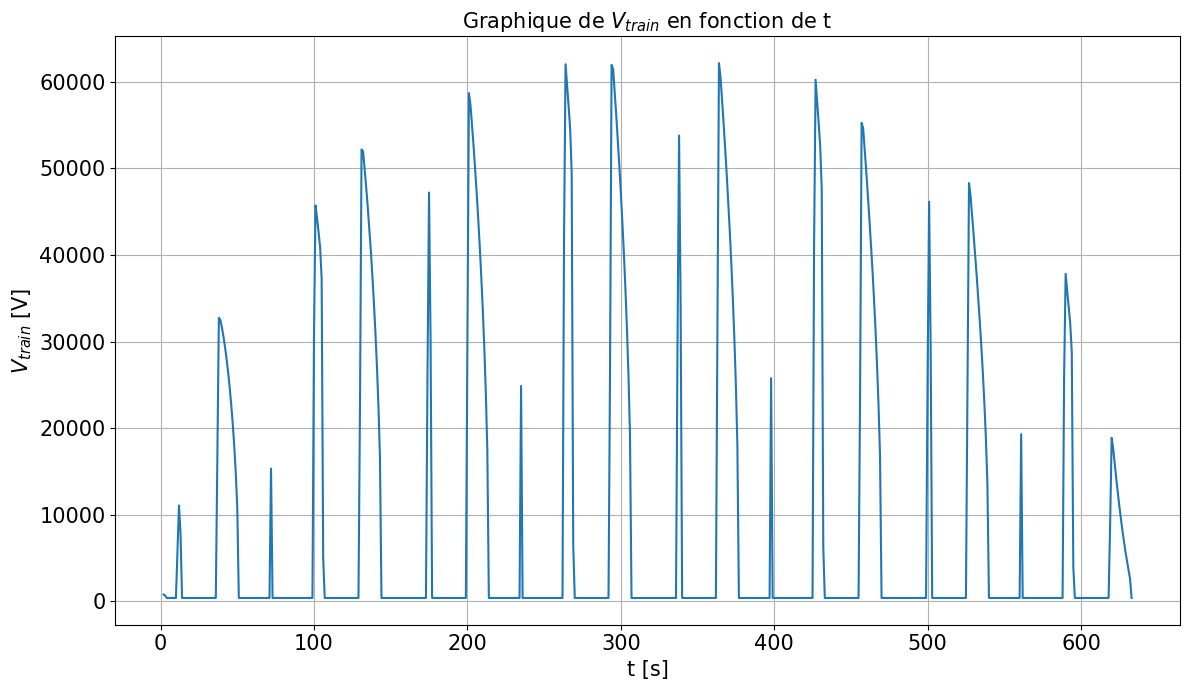

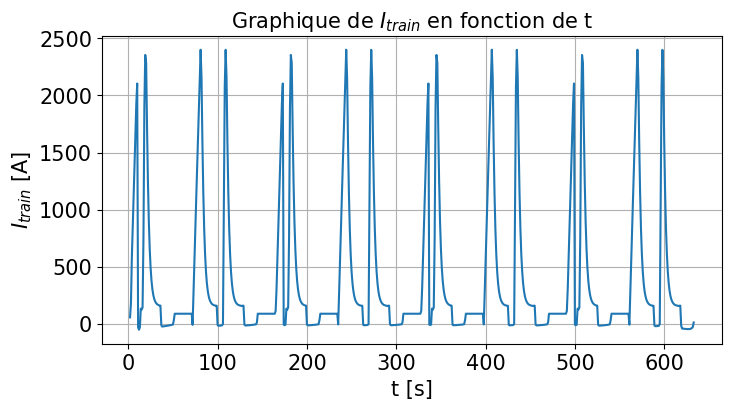

In [12]:
#Calcul de V_train
V_train = np.zeros(len(a))

for i in range(len(V_train)):
    if (P_train[i] <= (V_sst**2) / (4 * R_eq[i])):
        V_train[i] = 1/2 * (V_sst + np.sqrt(V_sst**2 - 4 * R_eq[i] * P_train[i]))  
    else:
        V_train[i] = 1/2 * V_sst
        
plt.figure(7, figsize = (12,7))
plt.plot(t[2:], V_train)
plt.xlabel('t [s]')
plt.ylabel('$V_{train}$ [V]')
plt.title('Graphique de $V_{train}$ en fonction de t')
plt.grid(True)

plt.tight_layout()

#Calcul de I_train
I_train = P_train / V_train
plt.figure(8, figsize = (8,4))
plt.plot(t[2:], I_train)
plt.xlabel('t [s]')
plt.ylabel('$I_{train}$ [A]')
plt.title('Graphique de $I_{train}$ en fonction de t')
plt.grid(True)

### **H - Calcul de $I_1$ et $I_2$ et $P_{sst1}$ et $P_{sst2}$**

On peut déterminer du calcul précédent les intensités et les puissances dans les deux branches :

$I_1 = V_{sst}/R_{eq1}$

$I_2 = V_{sst}/R_{eq2}$

$P_{sst1} = V_{sst} * I_1$

$P_{sst2} = V_{sst} * I_2$

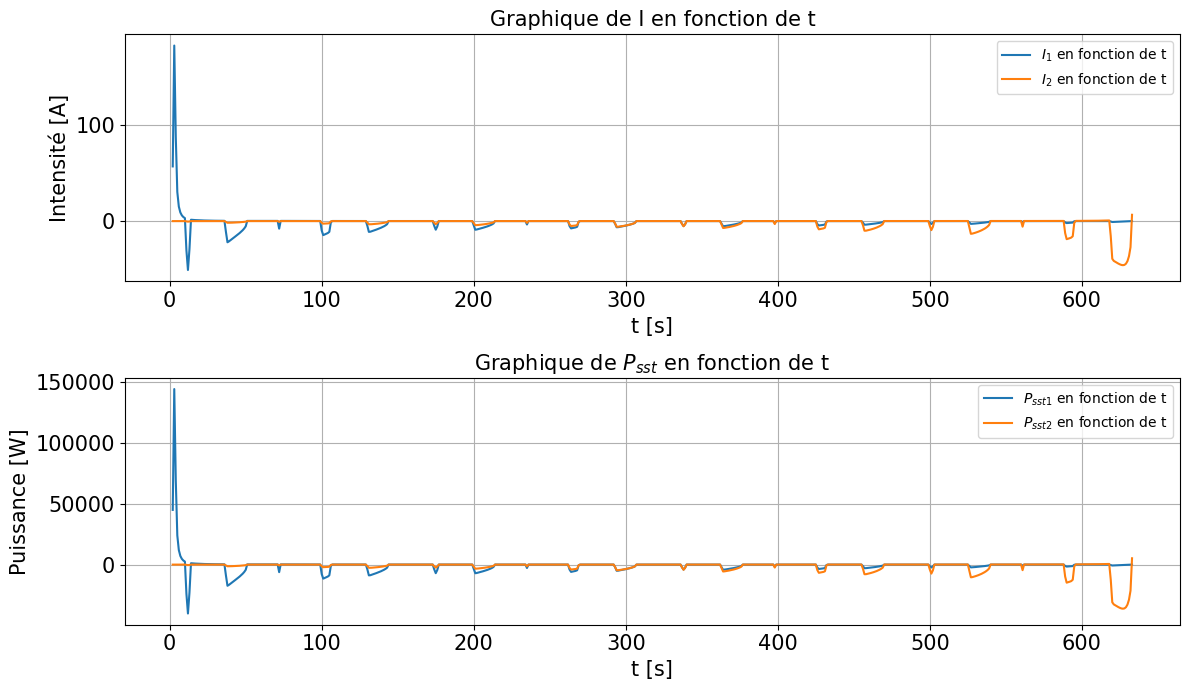

In [13]:
#%%  Calcul de I1 et I2  Psst1 et Psst2 
I_1 = (V_sst-V_train)/R_eq1[:-2]
I_2 = (V_sst-V_train)/R_eq2[:-2]

#Calcul des puissances Psst1 et Psst2
P_sst1 = V_sst*I_1
P_sst2 = V_sst*I_2

plt.figure(9, figsize = (12,7))
plt.subplot(2,1,1)
plt.plot(t[2:], I_1, label="$I_1$ en fonction de t")
plt.plot(t[2:], I_2, label="$I_2$ en fonction de t")
plt.xlabel('t [s]')
plt.ylabel('Intensité [A]')
plt.title('Graphique de I en fonction de t')
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.plot(t[2:], P_sst1, label="$P_{sst1}$ en fonction de t")
plt.plot(t[2:], P_sst2, label="$P_{sst2}$ en fonction de t")
plt.xlabel('t [s]')
plt.ylabel('Puissance [W]')
plt.title('Graphique de $P_{sst}$ en fonction de t')
plt.grid(True)
plt.legend()
plt.tight_layout()


## **III - Rajout d'une batterie**

La batterie peut se charger ou se décharger, elle se charge si $F_{motrice} < 0$ (freinage) et se décharge 
quand $F_{motrice} >= 0$ (accélération).

Lorsque le train accélère, la batterie fournit autant que possible. Si elle n'a pas assez d'énergie, alors la LAC fournit l'énergie nécessaire restante.

Lorsque le train freine, la batterie récupère l'énergie, et l'énergie en trop est dissipée par le rhéostat.

On prend pour modéliser $C_{batterie} = 5KWh$, capacité de la batterie que l'on optimisera par la suite.

In [14]:
#%% Initialisation des paramètres pour la gestion de la batterie et de la puissance dissipée

C_batt = 5000  # Capacité de la batterie en Wh (5 kWh)
P_batterie = np.zeros(len(P_train))  # État de charge de la batterie en Wh
P_batterie[0] = C_batt

V_train_batterie = np.zeros(len(P_train))  # Tension de la batterie
P_batterie = np.zeros(len(P_train))  # Puissance fournie par la batterie
P_rhéostat = np.zeros(len(P_train))  # Puissance dissipée dans le rhéostat
P_LAC = np.zeros(len(P_train))  # Puissance fournie par la LAC
Batterie_pleine = False

P_seuil = 450
for n in range(1,len(a)):
    if P_train[n-1] <= 0:
        P_LAC[n] = 0
        if P_train[n] <= C_batt:
            P_batterie[n] = P_train[n]
        else:
            P_batterie[n] = C_batt
            P_rhéostat[n] = P_train[n] - C_batt
    elif 0 < P_train[n-1] < P_seuil:
        P_LAC[n] = P_train[n]
        P_batterie[n] = 0
    elif P_train[n-1] >= P_seuil:
        P_LAC[n] = P_seuil
        P_batterie[n] = P_train[n] - P_seuil

#%% Graphiques de la tension du train avec la batterie et de l'état de charge

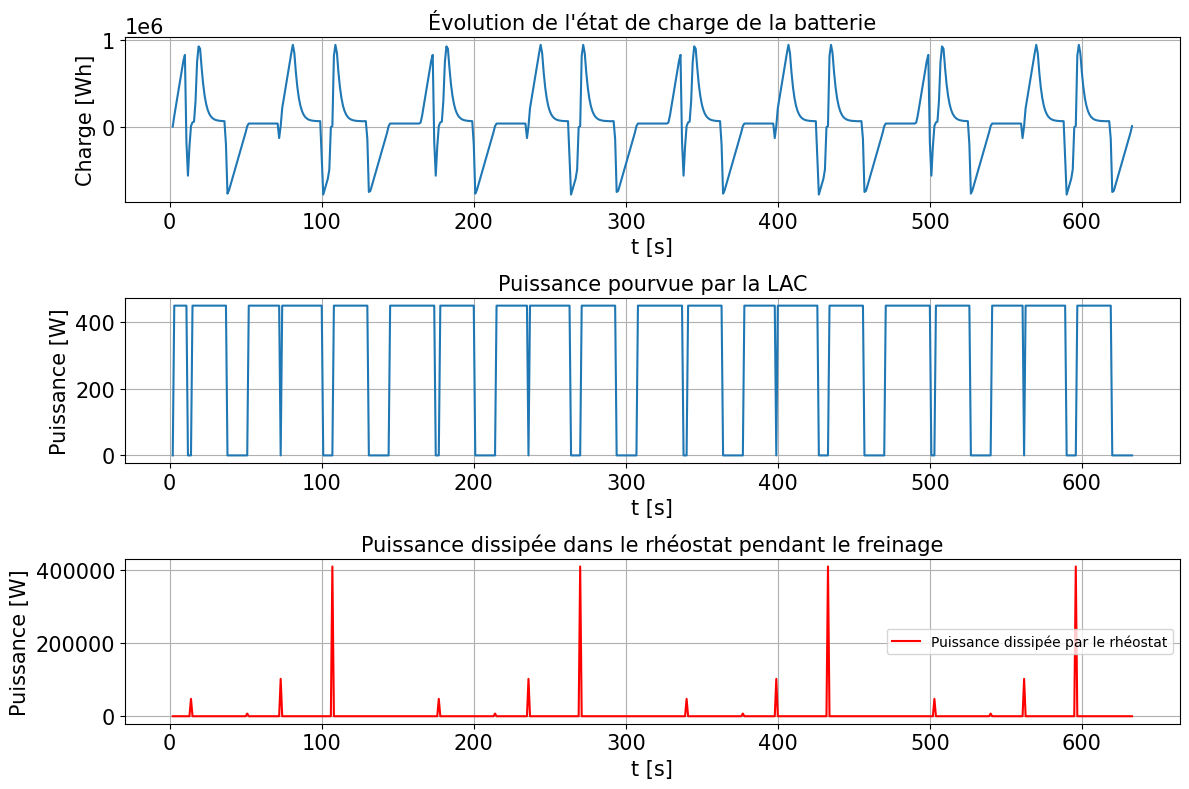

In [15]:
#%% Affichage de l'état de charge de la batterie et de la puissance dissipée par le rhéostat

plt.figure(figsize=(12, 8))

# État de charge de la batterie
plt.subplot(3, 1, 1)
plt.plot(t[2:], P_batterie)
plt.xlabel('t [s]')
plt.ylabel('Charge [Wh]')
plt.title("Évolution de l'état de charge de la batterie")
plt.grid(True)

# Puissance pourvue par la LAC
plt.subplot(3, 1, 2)
plt.plot(t[2:], P_LAC)
plt.xlabel('t [s]')
plt.ylabel('Puissance [W]')
plt.title("Puissance pourvue par la LAC")
plt.grid(True)

# Puissance dissipée dans le rhéostat
plt.subplot(3, 1, 3)
plt.plot(t[2:], P_rhéostat, label="Puissance dissipée par le rhéostat", color="red")
plt.xlabel('t [s]')
plt.ylabel('Puissance [W]')
plt.title("Puissance dissipée dans le rhéostat pendant le freinage")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## **Partie III - Dimensionnement du système de stockage**

Dans un premier temps, il faut prendre en compte qu'une tension trop basse est préjudiciable au bon fonctionnement du groupe moteur et les normes ferroviaires imposent que la tension d'alimentation du train ne doit jamais être inférieure à une certaine valeur $V_{min} = 500 V$. Approcher de cette valeur entrainerait des pertes par effet Joule importantes.

On se focalise sur la valeur maximale de la différence entre la tension nominale et la tension aux bornes du train au cours du trajet, et on utilise cette valeur comme critère pour qualifier la robustesse de l’alimentation électrique du train tout au long de son trajet.

La chute de tension dans les câbles et les rails est une fonction du courant consommé par le train et de la résistance du réseau. La tension aux bornes du train $V_{\text{train}}$ est calculée par :
$V_{\text{train}} = V_{\text{sst}} - \Delta V$
où :
$\Delta V = I_{\text{train}} \cdot R_{\text{sst}} + (\rho_{\text{LAC}} + \rho_{\text{rail}}) \cdot x$
et $I_{\text{train}}$ est le courant consommé par le train, $R_{\text{sso}}$ est la résistance de la sous-station, $\rho_{\text{LAC}}$ et $\rho_{\text{rail}}$ sont les résistances linéiques des câbles et des rails, respectivement, et $x$ est la distance parcourue par le train.

Dans un premier temps, on utilise la méthode de Monte Carlo et l'algorithme de Pareto pour déterminer les points non-dominées :

In [16]:
#faire pareto

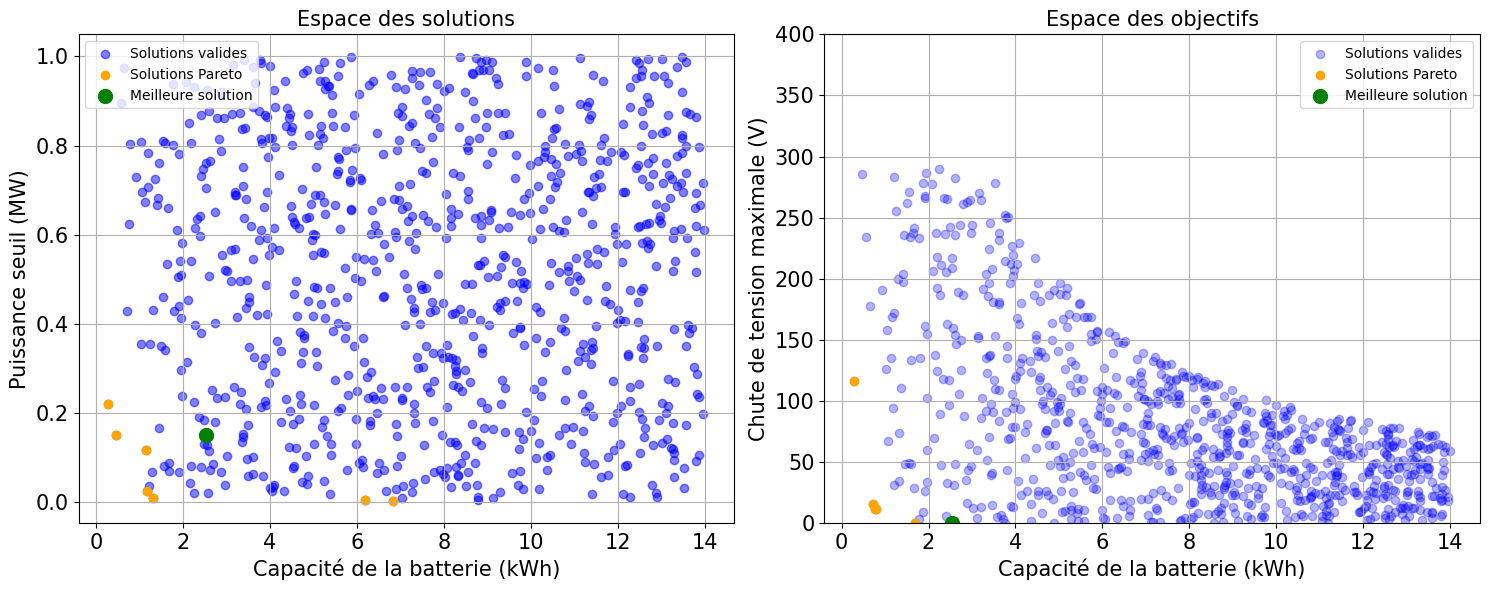

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du problème
N = 1000
  # Nombre de points d'échantillonnage
E_bat_min, E_bat_max = 0, 14  # Capacité de la batterie (en kWh)
P_seuil_min, P_seuil_max = 0, 1   # Puissance seuil (en MW)
V_nominal = 790  # Tension nominale du système (V)
V_min = 500  # Tension minimale admissible du train (V)

# Génération des échantillons (1000 couples capacité / puissance seuil)
np.random.seed(42)  # Pour la reproductibilité
E_bat = np.random.uniform(E_bat_min, E_bat_max, N)  # Capacités de batterie
P_seuil = np.random.uniform(P_seuil_min, P_seuil_max, N)   # Puissances seuil (en MW pour correspondre aux axes)

# Simuler les performances pour chaque configuration
P_train = np.random.uniform(0, 1, N)  # Simulation de la puissance demandée (en MW)
delta_V_max = np.zeros(N)  # Chute de tension maximale pour chaque configuration
valid = np.zeros(N, dtype=bool)  # Tableau de validité des configurations

# Calculer la chute de tension pour chaque couple de (capacité, puissance seuil)
for i in range(N):
    C_batt = E_bat[i] * 1000  # Conversion de la capacité de la batterie en Wh (kWh -> Wh)
    
    # Si la puissance demandée est inférieure au seuil, on n'utilise que la LAC
    if P_train[i] <= P_seuil[i] * 1000000:
        V_train = V_nominal - (P_train[i] * 1000000 / C_batt)  # La chute de tension pour P_train < P_seuil
    else:
        # Si la puissance demandée est supérieure au seuil, on utilise la batterie et la LAC
        V_train = V_nominal - (P_seuil[i] * 1000000 / C_batt)  # La chute de tension pour P_train >= P_seuil

    # Calcul de la chute de tension maximale
    delta_V_max[i] = V_nominal - V_train
    
    # Vérifier si la configuration est valide (si la tension est suffisante)
    if V_train >= V_min:
        valid[i] = True

# Extraire les performances des configurations valides
E_bat_valid = E_bat[valid]
delta_V_max_valid = delta_V_max[valid]
P_seuil_valid = P_seuil[valid]

# Identifier les solutions non dominées (Pareto) dans l'espace des objectifs
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

# Construire l'espace des objectifs
objectives = np.vstack((E_bat_valid, delta_V_max_valid)).T
pareto_mask_objectives = is_pareto_efficient(objectives)

# Solutions non dominées dans l'espace des objectifs (Pareto)
E_bat_pareto_objectives = E_bat_valid[pareto_mask_objectives]
delta_V_max_pareto_objectives = delta_V_max_valid[pareto_mask_objectives]

# Identifier les solutions non dominées (Pareto) dans l'espace des solutions (capacité, puissance seuil)
solutions = np.vstack((E_bat_valid, P_seuil_valid)).T
pareto_mask_solutions = is_pareto_efficient(solutions)

# Solutions non dominées dans l'espace des solutions (Pareto)
E_bat_pareto_solutions = E_bat_valid[pareto_mask_solutions]
P_seuil_pareto_solutions = P_seuil_valid[pareto_mask_solutions]

# Trouver la "meilleure" solution parmi les solutions Pareto dans l'espace des objectifs
# Critère : minimiser la chute de tension et maximiser la capacité de la batterie
best_solution_idx = np.argmin(delta_V_max_pareto_objectives)  # Choisir le meilleur selon la chute de tension

# Meilleure solution
best_E_bat = E_bat_pareto_objectives[best_solution_idx]
best_delta_V_max = delta_V_max_pareto_objectives[best_solution_idx]

# Affichage des résultats

# 1. Affichage de l'espace de solution (capacité et puissance seuil)
plt.figure(figsize=(15, 6))

# Espace des solutions
plt.subplot(1, 2, 1)
plt.scatter(E_bat_valid, P_seuil_valid, color='blue', alpha=0.5, label="Solutions valides")
plt.scatter(E_bat_pareto_solutions, P_seuil_pareto_solutions, color='orange', label="Solutions Pareto")
plt.scatter(best_E_bat, P_seuil_pareto_solutions[best_solution_idx], color='green', label="Meilleure solution", s=100)
plt.xlabel("Capacité de la batterie (kWh)")
plt.ylabel("Puissance seuil (MW)")
plt.title("Espace des solutions")
plt.legend()
plt.grid(True)

# Espace des objectifs avec ajustement de l'axe des ordonnées pour une meilleure visualisation
plt.subplot(1, 2, 2)
plt.scatter(E_bat_valid, delta_V_max_valid, label="Solutions valides", alpha=0.3, color='blue')
plt.scatter(E_bat_pareto_objectives, delta_V_max_pareto_objectives, color='orange', label="Solutions Pareto")
plt.scatter(best_E_bat, best_delta_V_max, color='green', label="Meilleure solution", s=100)
plt.xlabel("Capacité de la batterie (kWh)")
plt.ylabel("Chute de tension maximale (V)")
plt.title("Espace des objectifs")
plt.ylim(0, 400)  # Ajustez cette valeur selon vos résultats
plt.legend()
plt.grid(True)

# Affichage global
plt.tight_layout()
plt.show()


On trouve donc les solutions suivantes :

In [18]:
for i in range(len(E_bat_pareto_objectives)):
    print("Solution non dominée " + str(i + 1) + " :")
    print(" - Capacité de la batterie : " + str(E_bat_pareto_objectives[i]), "| Chute de tension maximale : " + str(delta_V_max_pareto_objectives[i]))

Solution non dominée 1 :
 - Capacité de la batterie : 0.28818292014123426 | Chute de tension maximale : 116.63980699067486
Solution non dominée 2 :
 - Capacité de la batterie : 0.7892569531129796 | Chute de tension maximale : 11.22991071350134
Solution non dominée 3 :
 - Capacité de la batterie : 1.6889021954084114 | Chute de tension maximale : 0.07975180851292407
Solution non dominée 4 :
 - Capacité de la batterie : 0.7666629435084387 | Chute de tension maximale : 11.78936474734246
Solution non dominée 5 :
 - Capacité de la batterie : 2.5400960912571624 | Chute de tension maximale : 0.004580439065307473
Solution non dominée 6 :
 - Capacité de la batterie : 0.7199613887795049 | Chute de tension maximale : 15.859160827262826


On enlève la 5e car elle suppose une trop grande capacité de la batterie, même si elle a la plus faible chute de tension :

In [19]:
E_bat_pareto_objectives = E_bat_pareto_objectives[E_bat_pareto_objectives != 2.5400960912571624]
delta_V_max_pareto_objectives = delta_V_max_pareto_objectives[delta_V_max_pareto_objectives != 0.004580439065307473]
for i in range(len(E_bat_pareto_objectives)):
    print("Solution non dominée " + str(i + 1) + " :")
    print(" - Capacité de la batterie : " + str(E_bat_pareto_objectives[i]), "| Chute de tension maximale : " + str(delta_V_max_pareto_objectives[i]))

Solution non dominée 1 :
 - Capacité de la batterie : 0.28818292014123426 | Chute de tension maximale : 116.63980699067486
Solution non dominée 2 :
 - Capacité de la batterie : 0.7892569531129796 | Chute de tension maximale : 11.22991071350134
Solution non dominée 3 :
 - Capacité de la batterie : 1.6889021954084114 | Chute de tension maximale : 0.07975180851292407
Solution non dominée 4 :
 - Capacité de la batterie : 0.7666629435084387 | Chute de tension maximale : 11.78936474734246
Solution non dominée 5 :
 - Capacité de la batterie : 0.7199613887795049 | Chute de tension maximale : 15.859160827262826


## **Principe de NSGA2 (Non-Sorted Genetic Algorithm 2)**

On va maintenant utiliser un algorithme génétique (NSGA2) pour trouver la solution la plus optimale possible :

- **Population initiale** de \( N \) solutions choisies aléatoirement
- Chaque individu est caractérisé par ses **gènes**, c'est-à-dire ses **variables de décision** (en gros, 1 variable de décision = 1 gène – **chromosome** = ensemble des gènes)

### A chaque génération (i.e chaque itération) :
1. **Classement des individus** (non dominés, puis non-dominés de rang 1, …)
2. **Sélection des 50% meilleurs individus**
3. **Génération de nouveaux individus** par croisement et mutation des individus sélectionnés

- Arrêt après un **certain nombre de générations**, fixé a priori.


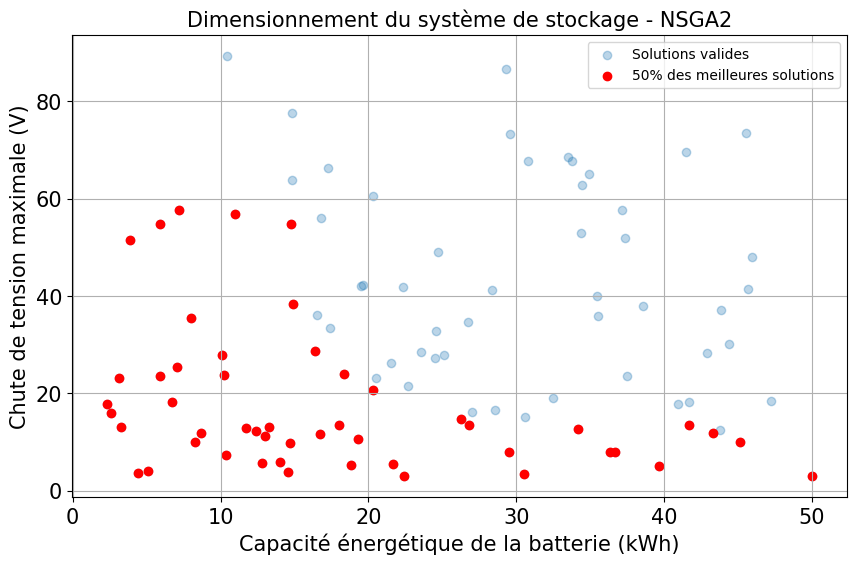

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de la simulation
N = 100  # Nombre de points échantillonnés
E_bat_min, E_bat_max = 1, 50  # Capacité de la batterie (kWh)
R_int_min, R_int_max = 0.01, 0.1  # Résistance interne de la batterie (ohms)
I_train_min, I_train_max = 100, 1000  # Courant demandé (A)
V_min = 500  # Tension minimale (V)

# Génération des points aléatoires dans l'espace de décision
np.random.seed(41)
E_bat = np.random.uniform(E_bat_min, E_bat_max, N)
R_int = np.random.uniform(R_int_min, R_int_max, N)
I_train = np.random.uniform(I_train_min, I_train_max, N)

# V = V_nominal - I_train * R_int
V_nominal = 790  # Tension nominale du système (V)
delta_V_max = I_train * R_int  # Chute de tension maximale
V_train = V_nominal - delta_V_max  # Tension réelle

# Cond qui satisfont la contrainte
valid = V_train >= V_min

# Extraire les performances des solutions valides
E_bat_valid = E_bat[valid]
delta_V_max_valid = delta_V_max[valid]

# Fonction pour le tri par non-dominance (NSGA-II)
def non_dominated_sort(costs):
    """
    Effectue un tri non-dominé et renvoie les indices des différents fronts de Pareto.
    """
    fronts = []
    dominance_count = np.zeros(costs.shape[0])  # Nombre de solutions qui dominent chaque solution
    dominated_solutions = [[] for _ in range(costs.shape[0])]  # Liste des solutions dominées par chaque solution

    for p in range(costs.shape[0]):
        for q in range(costs.shape[0]):
            if np.all(costs[p] <= costs[q]) and np.any(costs[p] < costs[q]):
                dominated_solutions[p].append(q)
            elif np.all(costs[q] <= costs[p]) and np.any(costs[q] < costs[p]):
                dominance_count[p] += 1

        if dominance_count[p] == 0:
            fronts.append([p])

    front_index = 0
    while len(fronts[front_index]) > 0:
        next_front = []
        for p in fronts[front_index]:
            for q in dominated_solutions[p]:
                dominance_count[q] -= 1
                if dominance_count[q] == 0:
                    next_front.append(q)
        front_index += 1
        fronts.append(next_front)
    
    return fronts[:-1]  # Retirer le dernier élément vide

# Construire l'espace des objectifs
objectives = np.vstack((E_bat_valid, delta_V_max_valid)).T

# Appliquer le tri par non-dominance
fronts = non_dominated_sort(objectives)

# Calculer 50% de la population
target_population_size = N // 2  # 50% des individus

# Sélectionner les 50% meilleurs individus
selected_indices = []
selected_count = 0
remaining_population = list(range(N))  # Liste de tous les indices valides

while selected_count < target_population_size:
    # Recalculer les fronts de Pareto sur les solutions restantes
    remaining_objectives = objectives[remaining_population]
    fronts_remaining = non_dominated_sort(remaining_objectives)

    # Si le front courant dépasse le quota restant, prendre seulement ce qui reste
    for front in fronts_remaining:
        if selected_count + len(front) <= target_population_size:
            selected_indices.extend([remaining_population[i] for i in front])
            selected_count += len(front)
        else:
            remaining = target_population_size - selected_count
            selected_indices.extend([remaining_population[i] for i in front[:remaining]])
            selected_count = target_population_size
            break

    # Mettre à jour la population restante (en enlevant les solutions sélectionnées)
    remaining_population = [i for i in remaining_population if i not in selected_indices]

# Extraire les solutions sélectionnées
E_bat_selected = E_bat_valid[selected_indices]
delta_V_max_selected = delta_V_max_valid[selected_indices]
# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.scatter(E_bat_valid, delta_V_max_valid, label="Solutions valides", alpha=0.3)
plt.scatter(E_bat_selected, delta_V_max_selected, color='red', label="50% des meilleures solutions")
plt.xlabel("Capacité énergétique de la batterie (kWh)")
plt.ylabel("Chute de tension maximale (V)")
plt.title("Dimensionnement du système de stockage - NSGA2")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
print(len(E_bat_selected)/len(E_bat_valid)*100) #bien 50% des meilleures

print(len(E_bat_selected)) #bien 50% des meilleures
for i in range(len(E_bat_selected)) :
    print(E_bat_selected[i], end='\t')
    print(delta_V_max_selected[i])
    

50.0
50
3.258695212957976	13.172166988044205
4.406502922768668	3.5758407758404545
49.97411475622601	3.008060236420884
2.3277554469330366	17.883082278071218
22.4157588951628	3.1523000385683537
2.597910917571813	15.918551404575183
5.076698638110728	4.090929158271326
14.548866476277665	3.9453214309102504
30.52039030336041	3.369120927759861
3.130004796592851	23.18146866348617
6.704761455160033	18.310416170200416
10.355602476207217	7.335392191367118
39.677621729605235	5.103383519912578
12.806439714010468	5.664010605691002
18.846837275983358	5.3485744879961095
8.2598935417629	10.02453437564669
5.901537399233374	23.675977957699626
3.8846518144182283	51.406260798591674
14.050013687830145	5.900555473914868
21.66614384075629	5.551545620083196
12.975485301717429	11.213582265179689
8.658067165445729	11.83727679311114
12.378906116224355	12.376487917126987
29.529007763300708	8.03812943487794
11.686296996811365	12.824163151173893
14.723519566052671	9.775530586347994
5.910239946020706	54.8597867741133

In [54]:
print(E_bat_selected)
print(delta_V_max_selected)

[ 3.25869521  4.40650292 49.97411476  2.32775545 22.4157589   2.59791092
  5.07669864 14.54886648 30.5203903   3.1300048   6.70476146 10.35560248
 39.67762173 12.80643971 18.84683728  8.25989354  5.9015374   3.88465181
 14.05001369 21.66614384 12.9754853   8.65806717 12.37890612 29.52900776
 11.686297   14.72351957  5.91023995 10.23386049  7.07928679 36.69436788
 36.35353144 13.29525756 19.27804835 16.74953569 34.16399581 10.1278311
  7.18497329 17.98448442  7.9956811  45.14204026 43.28615411 26.80280083
 41.64892306 16.41916976 20.30150245 18.34200034 26.23503649 14.86864812
 14.76908091 10.98113808]
[13.17216699  3.57584078  3.00806024 17.88308228  3.15230004 15.9185514
  4.09092916  3.94532143  3.36912093 23.18146866 18.31041617  7.33539219
  5.10338352  5.66401061  5.34857449 10.02453438 23.67597796 51.4062608
  5.90055547  5.55154562 11.21358227 11.83727679 12.37648792  8.03812943
 12.82416315  9.77553059 54.85978677 23.71436891 25.33665027  8.05047919
  8.06235692 13.09583995 10.

Nous allons désormais définir les fonctions visant à modifier les meilleures solutions par recombinaison et mutation.

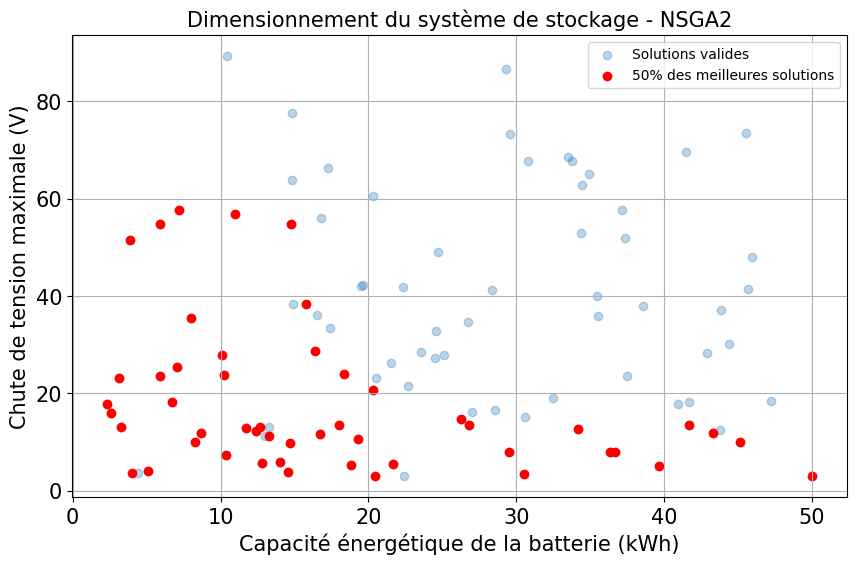

In [55]:
# Fonction de croisement
def crossover(parent1, parent2):
    """
    Effectue un croisement en un point entre deux parents.
    """
    alpha = np.random.uniform(0, 1)
    child = alpha * parent1 + (1 - alpha) * parent2
    return child

# Fonction de mutation
def mutate(individual, mutation_rate=0.1):
    """
    Applique une mutation gaussienne sur un individu.
    """
    if np.random.rand() < mutation_rate:
        mutation_strength = 0.1 * individual  # Modifier de ±10% la valeur
        individual += np.random.uniform(-mutation_strength, mutation_strength)
    return individual

#Probabilité de faire un croisement ou une mutation 50%
beta = np.random.random()

new_gen = []
for i in range(len(E_bat_selected)):
    if beta < 0.5 and i < len(E_bat_selected) - 1:
        new_gen.append(crossover(E_bat_selected[i],E_bat_selected[i+1]))
    else:
        new_gen.append(mutate(E_bat_selected[i]))

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.scatter(E_bat_valid, delta_V_max_valid, label="Solutions valides", alpha=0.3)
plt.scatter(new_gen, delta_V_max_selected, color='red', label="50% des meilleures solutions")
plt.xlabel("Capacité énergétique de la batterie (kWh)")
plt.ylabel("Chute de tension maximale (V)")
plt.title("Dimensionnement du système de stockage - NSGA2")
plt.legend()
plt.grid(True)
plt.show()

Il suffit maintenant de faire une boucle pour créer plusieurs générations successives.

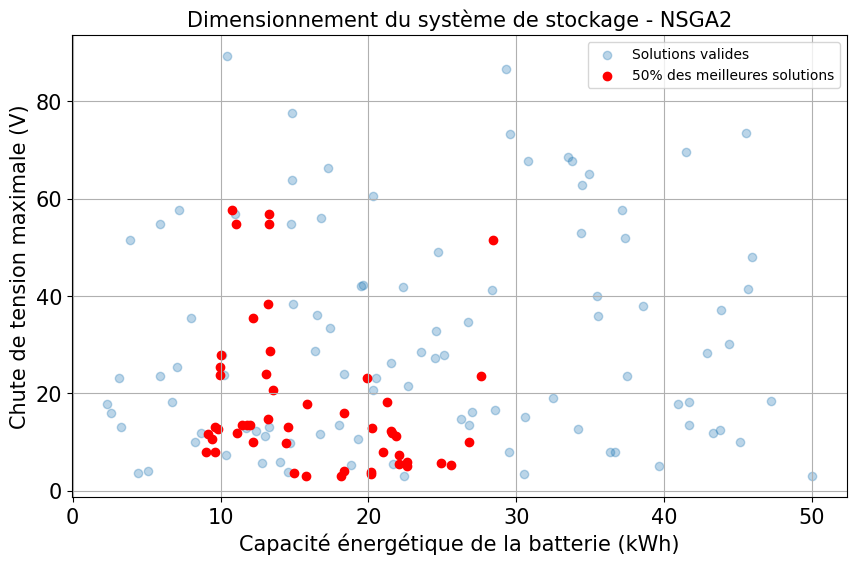

In [56]:
k = 100 #nb de générations

for k in range(100):
    #Probabilité de faire un croisement ou une mutation 50%
    beta = np.random.random()
    
    new_gen = []
    for i in range(len(E_bat_selected)):
        if beta < 0.5 and i < len(E_bat_selected) - 1:
            new_gen.append(crossover(E_bat_selected[i],E_bat_selected[i+1]))
        else:
            new_gen.append(mutate(E_bat_selected[i]))

    E_bat_selected = new_gen
    #temp += new_gen 
# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.scatter(E_bat_valid, delta_V_max_valid, label="Solutions valides", alpha=0.3)
plt.scatter(new_gen, delta_V_max_selected, color='red', label="50% des meilleures solutions")
plt.xlabel("Capacité énergétique de la batterie (kWh)")
plt.ylabel("Chute de tension maximale (V)")
plt.title("Dimensionnement du système de stockage - NSGA2")
plt.legend()
plt.grid(True)
plt.show()